# OpenStreetMap Data Case Study #
## Introduction ##
This project will study data from [OpenStreetMap](https://www.openstreetmap.org/#map=11/45.5428/-122.6544) with data munging techniques, such as assessing the quality of the data for validity, accuracy, completeness, consitency and uniformity, to clean the data for a part of the world. 

### OpenStreetMap ###
[OpenStreetMap (OSM)](https://en.wikipedia.org/wiki/OpenStreetMap)is a collaborative project to create a free editable map of the world. The creation and growth of OSM has been motivated by restrictions on use or availability of map information across much of the world, and the advent of inexpensive portable satellite navigation devices. OSM is considered a prominent example of volunteered geographic information.

Created by Steve Coast in the UK in 2004, it was inspired by the success of Wikipedia and the predominance of proprietary map data in the UK and elsewhere. Since then, it has grown to over 2 million registered users, who can collect data using manual survey, GPS devices, aerial photography, and other free sources. This crowdsourced data is then made available under the Open Database Licence. The site is supported by the OpenStreetMap Foundation, a non-profit organisation registered in England and Wales.

Rather than the map itself, the data generated by the OpenStreetMap project is considered its primary output. The data is then available for use in both traditional applications, like its usage by Craigslist, OsmAnd, Geocaching, MapQuest Open, JMP statistical software, and Foursquare to replace Google Maps, and more unusual roles like replacing the default data included with GPS receivers.  OpenStreetMap data has been favourably compared with proprietary datasources, though data quality varies worldwide.

### Map Area ###
+ [Portland, Oregon, U.S.](https://en.wikipedia.org/wiki/Portland,_Oregon)

+ DataSet from [Map Zen](https://mapzen.com/data/metro-extracts/your-extracts/f7754966b9be) (The OSM file is 901 MB uncompressed.)

This map is Portland, one of my favourite cities around the wourld. It is the largest city in the U.S state of Oregon. I have downloaded the metro area from Map Zen and I am curious to see the contributions to the map so far and what we can reveal from database query.

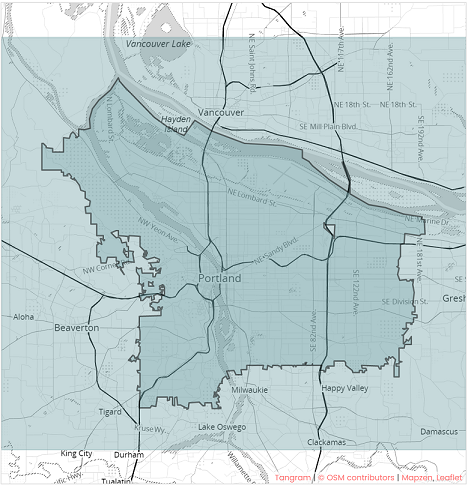

In [3]:
from IPython.display import Image
Image(filename='C:\Files\Udacity\Data-Analysis\Projects\OpenStreetMap Data Case Study\Portland_mapzen.png')

## Data Auditing ##
OSM is a collaborative project which relies on volunteers to contribute information, and there may be some inconsistent standards, incomplete entries and other factors that make data wrangling is necessary before processing.

### OSM XML file ###
Here is a shortened example of a complete OSM XML file from [OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/OSM_XML):
```XML
<?xml version="1.0" encoding="UTF-8"?>
<osm version="0.6" generator="CGImap 0.0.2">
 <bounds minlat="54.0889580" minlon="12.2487570" maxlat="54.0913900" maxlon="12.2524800"/>
 <node id="298884269" lat="54.0901746" lon="12.2482632" user="SvenHRO" uid="46882" visible="true" version="1" changeset="676636" timestamp="2008-09-21T21:37:45Z"/>
 <node id="261728686" lat="54.0906309" lon="12.2441924" user="PikoWinter" uid="36744" visible="true" version="1" changeset="323878" timestamp="2008-05-03T13:39:23Z"/>
 <node id="1831881213" version="1" changeset="12370172" lat="54.0900666" lon="12.2539381" user="lafkor" uid="75625" visible="true" timestamp="2012-07-20T09:43:19Z">
  <tag k="name" v="Neu Broderstorf"/>
  <tag k="traffic_sign" v="city_limit"/>
 </node>
 ...
 <node id="298884272" lat="54.0901447" lon="12.2516513" user="SvenHRO" uid="46882" visible="true" version="1" changeset="676636" timestamp="2008-09-21T21:37:45Z"/>
 <way id="26659127" user="Masch" uid="55988" visible="true" version="5" changeset="4142606" timestamp="2010-03-16T11:47:08Z">
  <nd ref="292403538"/>
  <nd ref="298884289"/>
  ...
  <nd ref="261728686"/>
  <tag k="highway" v="unclassified"/>
  <tag k="name" v="Pastower Straße"/>
 </way>
 <relation id="56688" user="kmvar" uid="56190" visible="true" version="28" changeset="6947637" timestamp="2011-01-12T14:23:49Z">
  <member type="node" ref="294942404" role=""/>
  ...
  <member type="node" ref="364933006" role=""/>
  <member type="way" ref="4579143" role=""/>
  ...
  <member type="node" ref="249673494" role=""/>
  <tag k="name" v="Küstenbus Linie 123"/>
  <tag k="network" v="VVW"/>
  <tag k="operator" v="Regionalverkehr Küste"/>
  <tag k="ref" v="123"/>
  <tag k="route" v="bus"/>
  <tag k="type" v="route"/>
 </relation>
 ...
</osm>
```

#### Elements ####
+ **Nodes**:  "Nodes" are individual dots used to mark specific locations (such as a postal box). Two or more nodes are used to draw line segments or "ways".
+ **Ways**: A "way" is a line of nodes, displayed as connected line segments. "Ways" are used to create roads, paths, rivers, etc.
+ **Relations**: When "ways" or areas are linked in some way but do not represent the same physical thing, a "relation" is used to describe the larger entity they are part of. "Relations" are used to create map features, such as cycling routes, turn restrictions, and areas that are not contiguous. The multiple segments of a long way, such as an interstate or a state highway are grouped into a "relation" for that highway. Another example is a national park with several locations that are separated from each other. Those are also grouped into a "relation".

All types of data element (nodes, ways and relations) can have tags. An element can have no tags. Tags describe the meaning of the particular element to which they are attached.
A tag consists of two free format text fields; a 'key' and a 'value'. Each of these are Unicode strings of up to 255 characters. For example, highway=residential defines the way as a road whose main function is to give access to people's homes. An element cannot have 2 tags with the same 'key', the 'key's must be unique. e.g. you cannot have an element with both the amenity=restaurant and amenity=bar.

### Overview of Dataset ###
To get the feeling on how much of which data I can expect to have in the map, there is a file Iterative_parsing.py to process the map file and find out tags and their counts. The results as below:
```python
{'bounds': 1,
 'member': 49449,
 'nd': 4460225,
 'node': 3857031,
 'osm': 1,
 'relation': 4147,
 'tag': 3254631,
 'way': 530920}
 ```
 
And before processing the data and add it into your database, we should check the "k" value for each "tag" and see if there are any potential problems. Here is the four key type tag categories:
+ "lower", for tags that contain only lowercase letters and are valid,
+ "lower_colon", for otherwise valid tags with a colon in their names,
+ "problemchars", for tags with problematic characters, and
+ "other", for other tags that do not fall into the other three categories.

Result as below (after running Tag_Types.py):
```python
{'lower': 1611260, 'lower_colon': 1625141, 'other': 18230, 'problemchars': 0}
```

I am curious about how many unique users have contributed to the map in this particular area, Singapore. From exploring_users.py we can see the number of unique contributors is 1735.
```python
Number of unique users: 1038
```

### Problems Encountered in the Map ###
After taking a 2% sample of the 901 MB dataset by sample_file.py, now we can do an initial exploration and identify problems in the sample. 
#### Abbreviated Street Names ####
One of the problems I have encountered was the name abbreviation after running audit_street_names.py. For example, Ave/Avenue, St/Street, St./Street and Rd/Road. 

```python
{'212': set(['Southeast Highway 212']),
 'Ave': set(['Northeast 112th Ave']),
 'Botticelli': set(['Botticelli']),
 'Broadway': set(['Northeast Broadway', 'Southwest Broadway']),
 'Cervantes': set(['Cervantes']),
 'Falstaff': set(['Falstaff']),
 'Fieldcrest': set(['Southeast Fieldcrest']),
 'Highway': set(['Northeast Portland Highway',
                 'Southwest Beaverton Hillsdale Highway',
                 'Southwest Capitol Highway',
                 'Southwest Pacific Highway',
                 'Southwest Tualatin Valley Highway']),
 'Hotspur': set(['Hotspur']),
 'Loop': set(['Northeast Lija Loop',
              'Northeast Mariners Loop',
              'Northwest 117th Loop',
               ...
              'Southwest Shearwater Loop',
              'Southwest Turquoise Loop']),
 'Rd': set(['SW Canyon Rd', 'SW Scholls Ferry Rd']),
 'St': set(['SE Ankeny St']),
 'St.': set(['NW Raleigh St.', 'North Lombard St.']),
 'Touchstone': set(['Touchstone'])}
 ```
 #### Abbreviated Street Directions ####
 The other problem found here is the street directions abbreviation, for example, SW/Southwest, SE/Southeast and NW/Northwest.
 
 #### Inconsistent Zip Codes ####
 We can check zip codes with audit_zip_codes.py. The zip code of Portland is a 5 digits number in the range from 97086 to 97299.
 
 The result shows:
 ```python
 ['97225-6345', '97206-2635']
 ```
 
Here is the additioinal 4 digits number following the 5 digits zip code, and after searching I foud it is the +4 Zip format and the last 4 digits code is a specific delivery route. For information accuracy consideration, I will not change them because there seems no practical method to replace it. And we didn't see any other unusual format, so this field is fine for now.

#### Inconsistent Phone Number ####
After checking phone number format with audit_phone_number.py, we can found the inconsistence in our dataset. Our required format is "+1-###-###-####" (with regular expression: ```(\+1\-\d{3}\-\d{3}\-\d{4})```).

Result as below:
```python
set(['(360) 253-5117',
     ...
     '+01-503-639-1712',
     ...
     '+1  (503) 344-4925',
     ...
     '1-360-573-3131',
     ...
     '503-972-8780',
     ...
     '5037466920',])
```

## Data Cleaning and Database Preparation ##
### Abbreviated Street Name and Street Direction ###
The abbreviated street name and street direction are fixed together in function ```update_name(name, mapping)```in data.py, and the mapping dictionary included both possible street name and street direction as below:
```python
mapping = { "Ave": "Avenue",
            "Ave.": "Avenue",
            ...
            "Rd": "Road",
            ...
            "St": "Street",
            "St.": "Street",
            ...
            "SW": "Southwest",
            "SE": "Southeast",
            "NW": "Northwest",
            "NE": "Northeast"
            }
```
The street names and directions are fixed as below:
```python
NW Raleigh St. -> Northwest Raleigh Street
North Lombard St. -> North Lombard Street
...
SE Ankeny St -> Southeast Ankeny Street
SW Canyon Rd -> Southwest Canyon Road
SW Scholls Ferry Rd -> Southwest Scholls Ferry Road
...
```
### Inconsistent Phone Number ###
Fix inconsistent phone number with function ```update_phone_num``` to convert with format: "+1 ### ### ####".

In [8]:
def update_phone_num(child_dict):
    # Fix phone number to
    # Called by shape_element()
    if child_dict['key'] == 'phone':
        phone_num = child_dict['value']
        m = phone_type.match(phone_num)
        if m is None:
            # Remove all brackets
            if "(" in phone_num or ")" in phone_num:
                phone_num = re.sub("[()]", "", phone_num)
            # Replace all spaces to dashes
            if " " in phone_num or "  " in phone_num:
                phone_num = re.sub("[ ]+(?=\d)", "-", phone_num)
            # Add dashes for 10 straight numbers
            if re.match(r'\d{10}', phone_num) is not None:
                phone_num = phone_num[:3] + "-" + phone_num[3:6] + "-" + phone_num[6:]
            # Add country code
            if re.match(r'\d{3}\-\d{3}\-\d{4}', phone_num) is not None:
                phone_num = "+1" + phone_num
            elif re.match(r'\+01\-\d{3}\-\d{3}\-\d{4}', phone_num) is not None:
                phone_num = "+1" + phone_num[3:]
            elif re.match(r'1\s\d{3}\s\d{3}\s\d{4}', phone_num) is not None:
                phone_num = "+" + phone_num
            # Ignore tag if no area code and local number (<10 digits)
            elif sum(c.isdigit() for c in phone_num) < 10:
                return None

            child_dict['value'] = phone_num
    return child_dict

## Overview of the Data ##
This section contains basic statistics about the Portland OpenStreetMap dataset and the SQL queries used to gather them.
### File Sizes ###
```
Portland.osm     901 MB
Portland.db      665 MB
nodes.csv        337.1 MB
nodes_tags.csv   7.6 MB
ways.csv         35.6 MB
ways_nodes.csv   107 MB
ways_tags.csv    99.5 MB
```
### Number of Nodes ###
```SQL
SELECT COUNT(*) FROM nodes;
```
```
3857148
```

### Number of Ways ###
```SQL
SELECT COUNT(*) FROM ways;
```
```
531039
```

### Number of Unique Users ###
```SQL
SELECT COUNT(DISTINCT(e.uid))          
FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e;
```
```
1819
```

### Top 10 Contributing Users ###
```SQL
SELECT e.user, COUNT(*) as num
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e
GROUP BY e.user
ORDER BY num DESC
LIMIT 10;
```

```
lyzidiamond_imports|30758
Peter Dobratz_pdxbuildings|22400
baradam|4981
Mele Sax-Barnett|4905
Peter Dobratz|4845
Darrell_pdxbuildings|4125
Grant Humphries|3642
cowdog|3400
Werewombat|750
PJ Houser|627
```

### First Contribution ###
```SQL
SELECT timestamp FROM nodes UNION SELECT timestamp FROM ways
ORDER BY timestamp
LIMIT 1;
```
```
2007-07-23T00:30:05Z
```

### Number of Stops ###
```SQL
SELECT COUNT(*)
FROM nodes_tags
WHERE value LIKE '%stop%';
```
```
5129
```

### Number of Cafes ###
```SQL
SELECT COUNT(*)
FROM nodes_tags
WHERE value = 'cafe'
OR value = 'coffee_shop';
```
```
827
```

### Top 10 Amenities ###
```SQL
SELECT value, COUNT(*) AS num
FROM nodes_tags
WHERE key = 'amenity'
GROUP BY value
ORDER BY num DESC
LIMIT 10;
```

```
bicycle_parking|3139
waste_basket|841
bench|732
post_box|689
cafe|497
restaurant|462
fast_food|417
place_of_worship|392
drinking_water|316
doctors|221
```

## Additional Data Exploration and Dataset Improvement ##
From the "Top 10 Amenities" we found that the most amenity is bicycle_parking. Actually Portland is said to be a bicycle popular city, so I am wondering the percentage of way which is bicycle designated.
### Percentage of Bicycle Designated Way ###
```SQL
SELECT COUNT(*)
FROM (SELECT * FROM (ways_tags JOIN ways ON ways_tags.id = ways.id)
WHERE ways_tags.key = 'bicycle' AND ways_tags.value = 'yes' OR ways_tags.value = 'designated');
```

```
29174
```

```SQL
SELECT COUNT(DISTINCT(subq.id))
FROM (SELECT * FROM ways JOIN ways_tags ON ways.id = ways_tags.id
WHERE ways_tags.key != 'highway') AS subq;
```

```
518947
```

So the percentage of way which is bicycle designated is 5.62%. 
### Dataset Improvement ###
During data exploration, I noticed actually the naming of amenities can be improved with more consistency. For example, when I exploring number of cafes, both 'cafe' and 'coffee_shop' are used here. And when I exploring number of stops, I noticed there are 'bus_stop', 'tram_stop', 'stop' and also 'stop_position'. The 'bus_stop' and 'tram_stop' is good enough here but the 'stop' and 'stop_position' is not that clear.

This kind of naming problem should also happen to other area as well. This may be fixed by some rules for user data entry, like implementation of data validation. But it should be updated frequently because new naming category will appear, for example, maybe we will also see 'bicycle_stop' with the increasing usage of sharing bicycle.

## Conclusion ##
The Portland, OR, USA dataset is quite large. And it really has a lot of things to do to clean and improve the data. From this project, via the SQL query, I have known more information about this city, which I will visit in the future. And the dataset is pretty useful for us to get information from.

## Reference ##
https://codereview.stackexchange.com/questions/97599/phone-number-extraction-with-regular-expressions

https://stackoverflow.com/questions/17027952/regex-for-all-spaces-before-a-number

https://stackoverflow.com/questions/126524/iterate-a-list-with-indexes-in-python

https://regex101.com/r/tG4sN2/10

http://www.sqlitetutorial.net/sqlite-import-csv/